In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [22]:
data = yf.download("CSCO",start="2020-10-01", end="2021-10-01")   #cisco data from oct,2020 till oct,2021

[*********************100%***********************]  1 of 1 completed


In [23]:
data.head()                #cisco opening data 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-30,39.090000,39.700001,39.020000,39.389999,37.918121,27113200
2020-10-01,39.099998,39.310001,38.570000,38.799999,37.694679,20763500
2020-10-02,38.049999,38.549999,37.970001,38.270000,37.179775,24493000
2020-10-05,38.480000,38.790001,38.279999,38.570000,37.471233,26929100
2020-10-06,38.500000,39.349998,38.400002,38.570000,37.471233,28430800


In [24]:
data.tail()              #cisco closing data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-24,56.450001,56.810001,56.220001,56.730000,56.349331,13156400
2021-09-27,56.459999,56.669998,56.049999,56.220001,55.842754,13859500
2021-09-28,55.779999,55.990002,55.410000,55.520000,55.147453,17803200
2021-09-29,55.619999,55.980000,55.340000,55.480000,55.107719,14051700
2021-09-30,55.799999,55.900002,54.410000,54.430000,54.064766,18538000


In [25]:
ADJ = data[['Adj Close']]
ADJ.info()                                  #data frame 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2020-09-30 to 2021-09-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


array([<AxesSubplot:xlabel='Date'>], dtype=object)

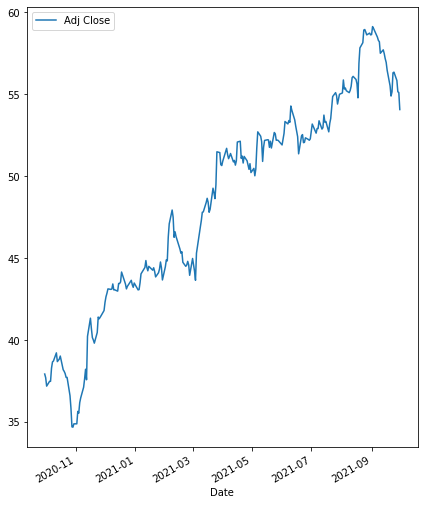

In [26]:
ADJ.plot(figsize=(7, 9), subplots=True)          #cisco closing data graph

In [27]:
ADJ.describe().round(1)     #description of the cisco data 

,Adj Close
count,253.0
mean,48.4
std,6.4
min,34.7
25%,43.5
50%,50.5
75%,53.2
max,59.1


In [28]:
returns = np.log(ADJ / ADJ.shift(1))
returns.head().round(5)                         #returns on cisco 

,Adj Close
Date,
2020-09-30,NaN
2020-10-01,-0.00591
2020-10-02,-0.01375
2020-10-05,0.00781
2020-10-06,0.00000


In [81]:
first_six_vol = round(data['Adj Close'][:125].pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(252)*100, 2)
first_six_vol, ('%')              #cisco volatility for the first 6 months

(22.47, '%')

In [79]:
last_six_vol = round(data['Adj Close'][125:].pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(252)*100, 2)
last_six_vol,('%')                 #cisco volatility for the last 6 months

(15.8, '%')

In [31]:
vol = np.sqrt(252) * returns.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is Adj Close    19.36
dtype: float64 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

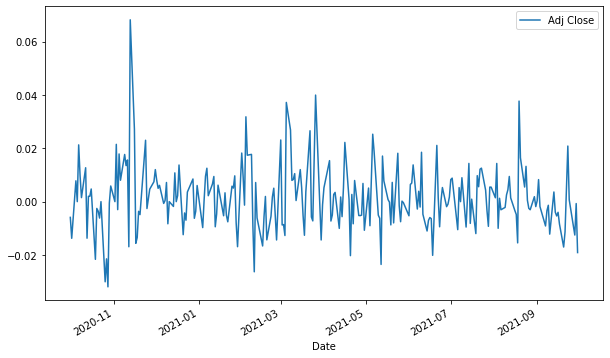

In [84]:
returns.dropna(inplace=True)
returns.plot(subplots=True, figsize=(10, 6))    #volatility of graph of cisco 

array([[<AxesSubplot:xlabel='Adj Close', ylabel='Adj Close'>]],
      dtype=object)

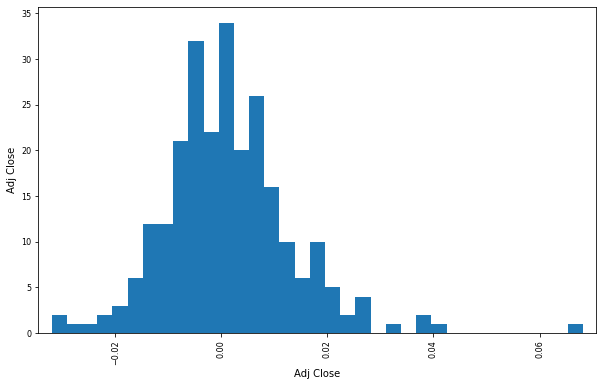

In [85]:
pd.plotting.scatter_matrix(returns, alpha=0.2, diagonal='hist', hist_kwds={'bins': 35}, figsize=(10, 6)) #historgram for volatility 

# QUESTION 2

## EUROPEAN CALL OPTION WITH BLACK–SCHOLES MODEL

In [32]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 54.06


In [33]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [34]:
S = 54.06
K = 58
T = 1
q = 0.027
r = 0.0134
vol = 0.1936

In [35]:
Call = euro_option_bsm(54.06,58, 1, 0.027, 0.0134, 0.1936, 'call')
print('The black scholes call price is', round(Call, 6))

The black scholes call price is 2.856116


In [36]:
S = np.linspace(1,80,90)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 58, 1, 0.027, 0.0134, 0.1936, 'call')

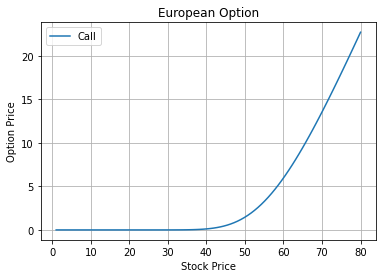

In [37]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Call','Put'])

## MONTE CARLO SIMULATION

In [38]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [42]:
T = 1
r = 0.0134
sigma = 0.1936
S0 = 54.06 
K = 58

In [43]:
S = mcs_simulation_np(10000)

In [44]:
S = np.transpose(S)
S

array([[54.06      , 53.93546895, 54.06180492, ..., 49.99228002,
        50.09097555, 50.01933344],
       [54.06      , 54.07355299, 53.99936154, ..., 55.99847944,
        55.92648999, 55.90448031],
       [54.06      , 54.318896  , 54.5068695 , ..., 58.70135685,
        58.76824813, 58.66849554],
       ...,
       [54.06      , 53.96021609, 54.09302586, ..., 40.24229872,
        40.23743525, 40.35329602],
       [54.06      , 54.04260064, 54.08103393, ..., 54.83815072,
        54.78326238, 54.7919713 ],
       [54.06      , 54.1378582 , 54.2138246 , ..., 69.05700094,
        69.15391959, 69.11066543]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

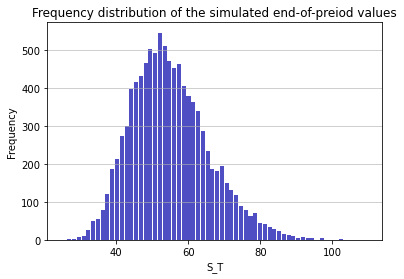

In [45]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [46]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', round(c))

European call 3


# QUESTION 3

## GREEKS

### DELTA

In [47]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [48]:
delta(54.06, 58, 1, 0.0134, 0.027, 0.1936, 'call')       

0.35832055674550245

In [49]:
S = np.linspace(1,100,80)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 58, 1, 0.0134, 0.027, 0.1936, 'call')

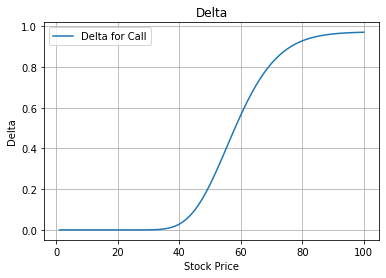

In [50]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call'])

In [51]:
S = np.linspace(1, 100, 40)
T = np.linspace(0.5, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 58, T[i], 0.0134, 0.027, 0.1936, 'call')

C:\Users\OLUDAI~1\AppData\Local\Temp/ipykernel_11444/1552531123.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


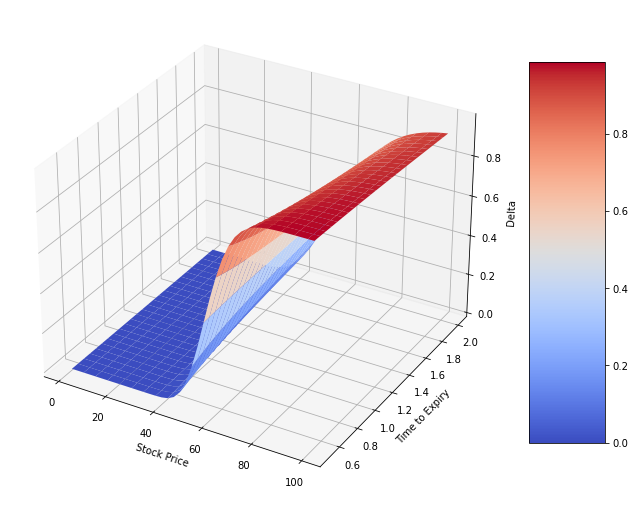

In [52]:
fig = plt.figure(figsize=(11, 14))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

### GAMMA

In [53]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [54]:
gamma(54.06, 58, 1, 0.0134, 0.027, 0.1936, 'call')

0.0350564662597109

In [55]:
S = np.linspace(1,120,80)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 58, 1, 0.0134, 0.027, 0.1936, 'call')

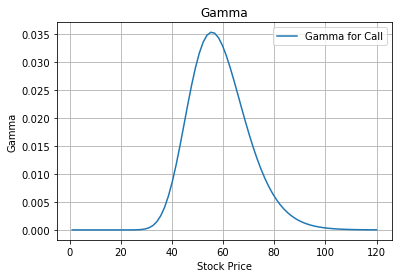

In [56]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call'])

In [57]:
S = np.linspace(1, 120, 80)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 58, T[i], 0.0134, 0.027, 0.1936, 'call')

C:\Users\OLUDAI~1\AppData\Local\Temp/ipykernel_11444/3072304221.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


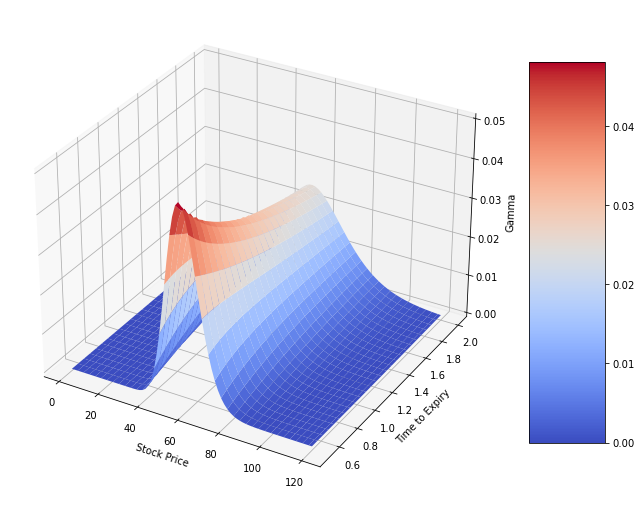

In [58]:
fig = plt.figure(figsize=(11, 14))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

### SPEED

In [59]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [60]:
speed (54.06, 58, 1, 0.0134, 0.027, 0.1936, 'call')

0.00047971658874346103

In [61]:
S = np.linspace(1,120,80)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 58, 1, 0.0134, 0.027, 0.1936, 'call')

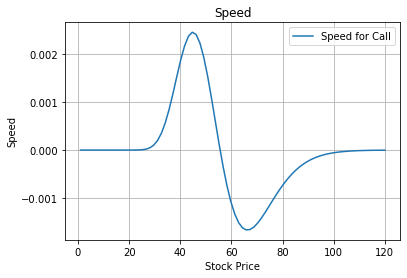

In [62]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call'])

In [63]:
S = np.linspace(1, 120, 80)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 58, T[i], 0.0134, 0.027, 0.1936, 'call')

C:\Users\OLUDAI~1\AppData\Local\Temp/ipykernel_11444/1603304871.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


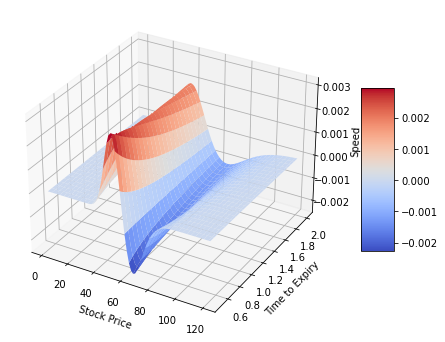

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [65]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [66]:
rho (54.06, 58, 1, 0.0134, 0.027, 0.1936, 'call')

17.04884766248042

In [67]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(54.06, 58, 1, r[i], 0.027, 0.1936, 'call')

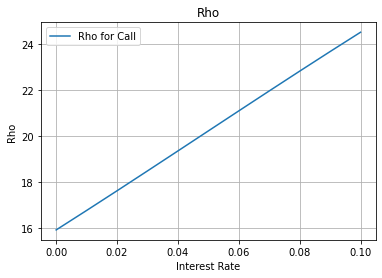

In [68]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call'])

In [69]:
S = np.linspace(1,120, 80)
T = np.linspace(0.5, 2, 51)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 58, T[i], 0.0134, 0.027, 0.1936, 'call')

C:\Users\OLUDAI~1\AppData\Local\Temp/ipykernel_11444/2235945349.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


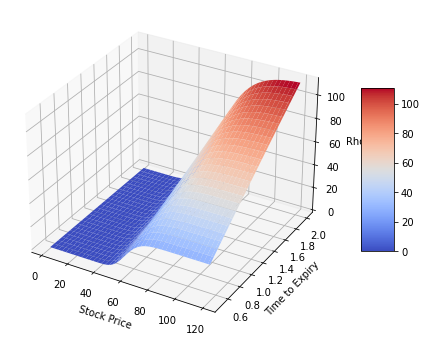

In [70]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

### VEGA

In [71]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [72]:
vega (54.06, 58, 1, 0.0134, 0.027, 0.1936, 'call')

19.834697078196754

In [73]:
vol = np.linspace(0.1,0.9,40)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(54.06, 58, 1, 0.0134, 0.027, vol[i], 'call')

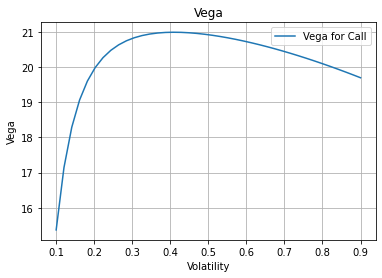

In [74]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call'])

In [75]:
S = np.linspace(1, 110, 51)
T = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 58, T[i], 0.0134, 0.027, 0.1936,'call')

C:\Users\OLUDAI~1\AppData\Local\Temp/ipykernel_11444/2704700163.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


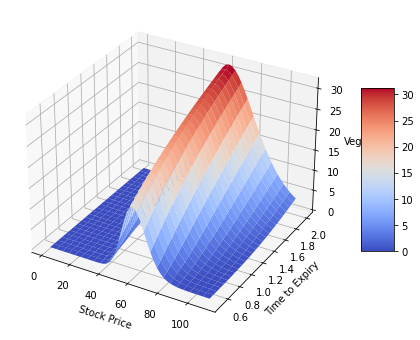

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);